<p style="text-align:left; font-size:90%">
    MBUSA Machine Learning
    <span style="float:right;">© 2024 University of Melbourne (excluding links to external images)</span>
</p>

# Workshop 2: Decision Trees & Ensemble Methods
***
In this worksheet we cover:
* [Decision trees](#2a:-Decision-Trees)
* [Ensemble methods: bagging and boosting](#Workshop-2b:-Ensemble-Methods,-bagging-and-boosting)

In [1]:
#import the packages we need for the coding questions.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

***
## 2a: Decision Trees

### Entropy
Entropy is a measure of the _average information_ produced by a random process, or contained within a random sample. It can also be viewed as a measure of _diversity_ or _purity_.

Given a categorical random variable, the information entropy is defined as:
$$
H(X) = - \sum_{x} p(x) \log_2 p(x)
$$
where $p(x)$ is the probability mass associated with category $x$.

<blockquote style="padding: 10px; background-color: #fef5e7;">

#### Quick Question 1 (Pen/paper)
***Entropy***

Consider repeatedly tossing a coin. Calculate the entropy per toss in the following cases:

1. The coin is fair (probability of heads/tails is $0.5$).
2. The coin is biased so that the probability of heads is $0.7$ and the probability of tails is $0.3$.
3. The coin only returns heads (probability of tails is $0$).
</blockquote>

In [2]:
import math
print(-1 * (1/2 * math.log2(1/2)*2))
print(-1 * (0.7*math.log2(0.7)+0.3*math.log2(0.3)))
print(-1 * (1*math.log2(1)))

1.0
0.8812908992306927
-0.0


### Information gain
Information gain is a commonly used metric for assessing the quality of splits in decision trees. It's used in the ID3, C4.5 and C5 decision tree algorithms.

Information gain is closely linked to information entropy. It measures the amount of information _gained_ about a random variable $Y$ after observing another random variable $X$. It's defined as follows:
$$
IG(Y,X) = H(Y) - H(Y|X)
$$
The second term is the conditional entropy. Assuming $X$ is discrete, it can be expressed as follows:
$$
H(Y|X) = \sum_{x} p(x) H(Y\vert X=x)
$$

<blockquote style="padding: 10px; background-color: #fef5e7;">
    
#### Quick Question 2 (Pen/paper)
***Information gain***

Consider the following binary classification data set. We'd like to determine a good splitting rule for the first node in the tree. Note that features A and B are binary and feature C is continuous.

Feature A | Feature B | Feature C | Class Label
--- | --- | --- | ---
T | F | 6 | +
T | T | 7 | +
T | T | 8 | +
T | F | 6.5 | -
T | T | 5 | +
F | F | 5.5 | -
F | F | 4 | -
F | F | 4.5 | -
T | T | 3 | -
T | F | 2 | -

1. Compute the information gain when splitting on feature A.
2. Compute the information gain when splitting on feature B.
3. Of features A and B, which produces the best split?
4. What if we wanted to consider feature C for splitting? How could we compute the information gain?
</blockquote>

In [3]:
def entropy(probability_list):
    H = 0
    for probability in probability_list:
        H += probability*math.log2(probability)
    return -1*H
entropy([2/5,3/5]) # full entropy

entropy([2/5,3/5]) - (7/10 * entropy([4/7, 3/7]) + 3/10 * entropy([1]))
entropy([2/5,3/5]) - (4/10 * entropy([3/4, 1/4]) + 6/10 * entropy([1/6, 5/6]))

# feature c
entropy([2/5,3/5]) - (6/10 * entropy([1/6, 5/6]) + 4/10 * entropy([3/4, 1/4]))

0.256425891682003

In [ ]:
entropy([2/5,3/5])

### Decision trees
In lectures, we covered the Iterative Dichotomiser 3 (ID3) algorithm for fitting a decision tree.
The default model in sklearn is Classification and Regression Trees (CART), that uses Gini as the split criterion.
If you want to use ID3, you just have to set the attribute criterion: "entropy", instead of the default value, which is Gini. 

The table below summarises how the three most popular decision tree algorithms differ.

 Algorithm | Splitting criterion | Supported attribute types | Supports missing values | Pruning strategy | Outlier detection 
 --- | --- | --- | --- | --- | ---
ID3  | Information gain | Categorical | No | None | Susceptible to outliers
CART | Gini or twoing | Categorical and numeric | Yes | Cost complexity pruning | Handles outliers
C4.5 | Gain ratio | Categorical and numeric | Yes | Error based pruning | Susceptible to outliers

Let's fit a decision tree using scikit-learn.
But first we'll load some data from the [UCI Machine Learning repository](https://archive.ics.uci.edu/ml/index.php).
The data set we'll be using contains records for 45,211 telemarketing customer interactions at a Portuguese bank. 
The goal is to predict whether the customer will sign up for the product—i.e. a binary classification task. 
There are 16 mixed (categorical/numeric) features for each customer interaction. 

The code block below downloads the data from the repository, unzips it, and reads the full CSV file into a `pandas.DataFrame`.

In [4]:
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen

resp = urlopen('https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip')
zipfile = ZipFile(BytesIO(resp.read()))
# !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip
# zipfile = ZipFile("bank.zip")

df = pd.read_csv(zipfile.open('bank-full.csv'), header=0, sep=';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


Notice that several features are categorical. We must therefore apply feature encoding to encode categorical features as arrays. A straightforward solution is to apply the pandas.get_dummies function to one-hot encode all of the categorical columns in the DataFrame. We then cast the result to a NumPy array called X. Notice that we exclude the labels, which are stored in column y.

We also re-encode the labels—0 for 'no' and 1 for 'yes'—and cast to a NumPy array.

In [5]:
df_transformed = pd.get_dummies(df.drop('y', axis=1)) # one hot encoding for all categorical variables
X = df_transformed.values
Y = df.y.map({'no':0, 'yes':1}).values

In [6]:
X[0]

array([  58, 2143,    5,  261,    1,   -1,    0,    0,    0,    0,    0,
          1,    0,    0,    0,    0,    0,    0,    0,    0,    1,    0,
          0,    0,    1,    0,    1,    0,    0,    1,    1,    0,    0,
          0,    1,    0,    0,    0,    0,    0,    0,    0,    0,    1,
          0,    0,    0,    0,    0,    0,    1])

Before training the decision tree, let's perform warm-up exercises to learn how to use sklearn for training, prediction and evaluation. We will train a basline model with Majority Class, which is the commonly used baseline in ML. 

The following are three useful functions, notice they are not only for the Majority class, but also for most sklearn training alrogithms (e.g. Decision Tree, Random Forest, etc.).

&emsp;&emsp;&emsp;&emsp;`fit`: train model from the training set.\
&emsp;&emsp;&emsp;&emsp;`predict`: makde prediction for the input samples.\
&emsp;&emsp;&emsp;&emsp;`score`: return the evaluate result on the given test data and labels. (e.g mean accuracy for classification)



In [7]:
from sklearn.dummy import DummyClassifier

ds_clf = DummyClassifier(strategy="most_frequent") # Define our model, set parameter strategy to 'most_frequent'
ds_clf.fit(X, Y) # Use model.fit to train with our dataset 
Y_predict = ds_clf.predict(X) # Use model.predict to make prediction on the training data
print("Prediction :", Y_predict[:10])
print("Accuracy:", ds_clf.score(X, Y)) # Use model.score to evaluate our model. mean accuracy of training data

Prediction : [0 0 0 0 0 0 0 0 0 0]
Accuracy: 0.8830151954170445


Great, we got an accuracy of 0.88. But does this mean that our model is very powerful? Is the evaluation result reliable?

<blockquote style="padding: 10px; background-color: #eafaf1;">

#### Question 3 (Coding)
Fit a decision tree to this data set using `sklearn.tree.DecisionTreeClassifier`.
You should partition your data into train/test with a 70:30 ratio.
Evaluate the tree on the test set using an appropriate measure.
</blockquote>

In [8]:
# Heldout - split dataset into training set and test set
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=1)

In [9]:
#Re-traini Majority class with heldout

ds_clf.fit(X_train, Y_train) # fill in
Y_predict = ds_clf.predict(X_test) # fill in
print("Prediction :", Y_predict[:10])
print("Accuracy on the test set:", ds_clf.score(X_test, Y_test)) # fill in

Prediction : [0 0 0 0 0 0 0 0 0 0]
Accuracy on the test set: 0.8856531996461221


In [10]:
#Decision tree model
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score


clf = DecisionTreeClassifier(random_state=42, max_depth=3)
clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred)
print("Prediction :", Y_pred[:10])
print("Accuracy on the test set:", accuracy)


Prediction : [0 0 1 1 0 0 1 0 0 0]
Accuracy on the test set: 0.9019463285166618


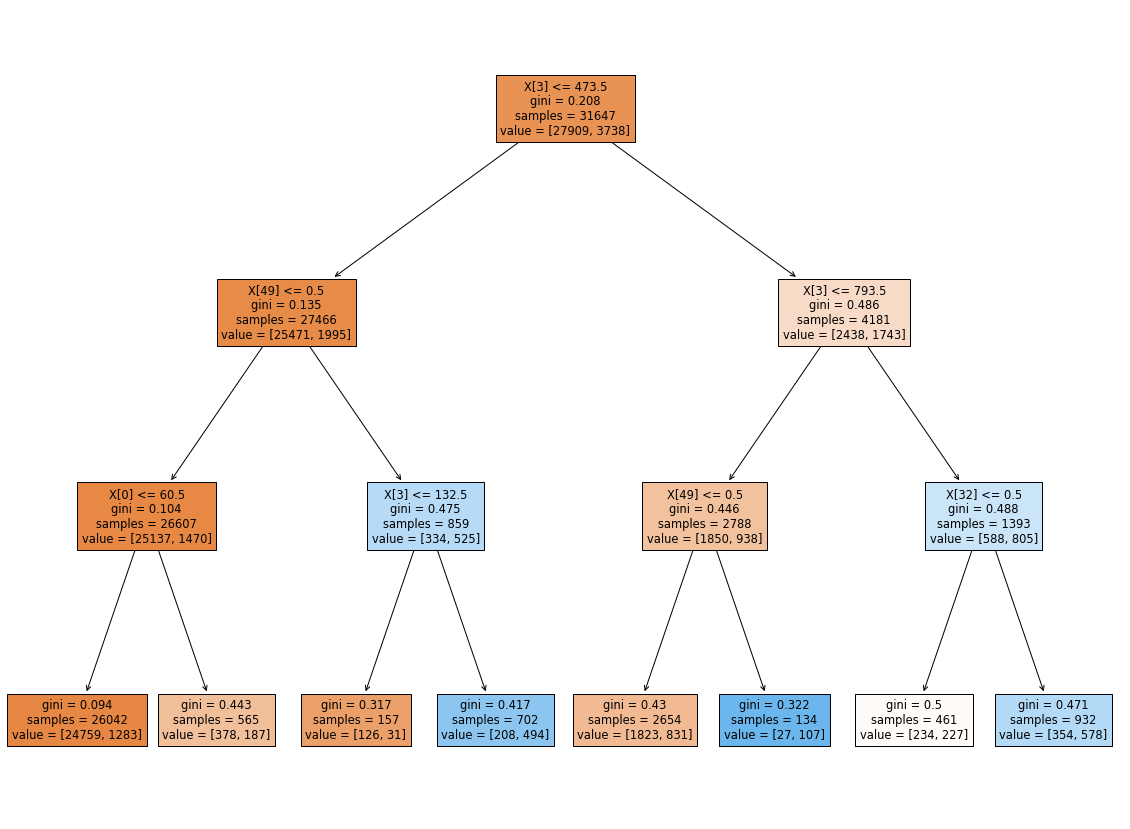

In [11]:
#plot the tree
from sklearn.tree import plot_tree

plt.figure(figsize=(20,15))
plot_tree(clf, filled=True)
plt.show()


<blockquote style="padding: 10px; background-color: #ebf5fb;">
    
#### Question 4 (Discussion)
What hyperparameters did you choose for the decision tree? Will using different values affect the model results? 
    
We mention pruning during the lecture. Could you find which parameter is for pruning in `sklearn.ensemble.RandomForestClassifier`. 
</blockquote>



In [12]:
# i choose depth of 3,

***
## Workshop 2b: Random Forest

The pseudo-code for the Random Forest training algorithm is as follows:

~~~
1  Parameters: n_trees (number of trees); max_features (size of random feature subset)
2  Initialise empty forest.
3  While size of forest is less than n_trees:
4      Create a bootstrap sample from the training data.
5      Train a decision tree on the sample (with max_features randomly-selected features available for each split).
6      Add tree to forest.
~~~


<blockquote style="padding: 10px; background-color: #eafaf1;">
    
#### Question 5 (Coding)
Fit a random forest model on the bank data using `sklearn.ensemble.RandomForestClassifier`. 
</blockquote>


In [13]:
### fill in
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(
    n_estimators = 100, # how many frees,
    max_depth= 10,
    random_state=42
)
rf_clf.fit(X_train, Y_train)
rf_y_pred = rf_clf.predict(X_test)
accuracy = accuracy_score(Y_test, rf_y_pred) 

print('Prediction: ', rf_y_pred)
print(f'Accuracy: {accuracy}')
rf_clf.score(X_test,Y_test) # accuracy_score is equalvalent to use .score 

Prediction:  [0 0 0 ... 0 0 1]
Accuracy: 0.9005455617811855


0.9005455617811855

<blockquote style="padding: 10px; background-color: #eafaf1;">

#### Question 6 (Code)
Experiment with the hyperparameters for the random forest classifier, such as:
- max_depth
- max_features
- max_leaf_nodes
- ...

Do they have an effect on the performance?
How would you tune these parameters to avoid overfitting?
</blockquote>

In the code block below, we test this statement empirically by varying the number of trees in the forest.
Note the effect on test accuracy and running time. You can also try to tune other hyperparameters.

In [14]:
for num_of_trees in [5, 10, 50, 100, 200]:
    print("===============================")
    time_1 = time.time()
    print('Set num_of_trees to {}'.format( num_of_trees ))
    rf_clf = RandomForestClassifier(
        n_estimators = num_of_trees, # how many frees,
        max_depth= 10,
        random_state=42
    )
    rf_clf.fit(X_train, Y_train)
    print('Fit finished in {:.3g}s'.format(time.time() - time_1))
    print('The test accuracy is {:.3g}'.format(rf_clf.score(X_test, Y_test))) # fill in

Set num_of_trees to 5
Fit finished in 0.0814s
The test accuracy is 0.899
Set num_of_trees to 10
Fit finished in 0.161s
The test accuracy is 0.899
Set num_of_trees to 50
Fit finished in 0.776s
The test accuracy is 0.901
Set num_of_trees to 100
Fit finished in 1.5s
The test accuracy is 0.901
Set num_of_trees to 200
Fit finished in 2.87s
The test accuracy is 0.9


## Extension questions

In this section, we're now going to implement a Random Forest from scratch using `sklearn.tree.DecisionTreeClassifier` as the base learner.

<blockquote style="padding: 10px; background-color: #eafaf1;">

#### Question 7 (Coding)
The following code block defines a `fit_forest` function, which takes in some training data and returns an ensemble of fitted decision trees.
Complete the missing parts with reference to the pseudo-code above. The results should be nearly identical to the ones you obtained using sklearn.
</blockquote>

In [15]:
def fit_forest(X, Y, n_trees, **kwargs):
    """
    Fit a Random Forest
    
    Arguments
    =========
    X : numpy array, shape: (n_instances, n_features)
        feature matrix
    Y : numpy array, shape (n_instances,)
    n_trees : int
        number of trees in the forest
    *kwargs : keyword arguments passed to DecisionTreeClassifier
    
    Returns
    =======
    a dictionary with two entries:
      'forest' : list of DecisionTreeClassifier instances
      'oob_score' : the out-of-bag accuracy
    """
    forest = []
    n_instances = X.shape[0]
    n_features = X.shape[1]
    
    # A matrix to store the out-of-bag predictions for each tree (in-bag are left as 'nan')
    oob_all_predictions = np.full([n_trees, n_instances], np.nan)
    
    for i in range(n_trees):
        bag_ids =  # fill in
        tree =  # fill in
        
        # Save predictions for out-of-bag instances
        oob_ids = np.setdiff1d(np.arange(n_instances), bag_ids)
        oob_all_predictions[i,oob_ids] = tree.predict(X[oob_ids])
        
        forest.append(tree) 
    
    # Compute the out-of-bag accuracy (majority vote)
    from scipy.stats import mode
    oob_vote_prediction = mode(oob_all_predictions, axis=0, nan_policy='omit')[0].flatten()
    oob_score = (oob_vote_prediction==Y).mean()
    
    return {'forest': forest, 'oob_score': oob_score}

SyntaxError: invalid syntax (2063222071.py, line 28)

Notice, this version is not strictly Random Foreset, because it's not doing the feature randomisation. It's only uses Bagging to a set of DecisionTrees.

Let's apply this function to fit a Random Forest of 100 trees to the bank data. 
Note that a larger forest is generally better, but performance will diminish beyond a certain size.
By setting `max_features='sqrt'`, we're restricting each split to a random subset of features of size $\sqrt{\mathrm{num\ features}}$ (i.e. a subset of 8 features for this data).

We also print out the out-of-bag accuracy, which we computed while fitting the trees.

In [ ]:
forest = fit_forest(X_train, Y_train, 10, max_features='sqrt')
print('Out-of-bag accuracy is {:.3g}'.format(forest['oob_score']))

<blockquote style="padding: 10px; background-color: #eafaf1;">

#### Question 8 (Coding)
Complete the `predict_forest` function below to make predictions for a set of instances `X` using the forest you just trained. Remember that for classification, a prediction is made by majority vote among trees in the forest.
</blockquote>

In [ ]:
def predict_forest(X, forest):
    """
    Make predictions using majority voting over the trees in the forest
    
    Arguments
    =========
    X : numpy array, shape: (n_instances, n_features)
        feature matrix
    forest : a list of DecisionTreeClassifier instances
    """
    # Allocate array to store predictions for each instance/tree
    n_instances = X.shape[0]
    n_trees = len(forest)
    predictions = np.empty([n_trees, n_instances], dtype=int)
    
    # Fill array
    for (i,tree) in enumerate(forest):
        predictions[i] =  # fill in
    
    # Use majority vote (mode) for each instance
    from scipy.stats import mode
    return mode(predictions, axis=0)[0].flatten()

Let's use the `predict_forest` function to compute the accuracy on the test set. You should compare the test accuracy to the out-of-bag accuracy computed previously and to the test accuracy for the decision tree (from the previous section).

In [ ]:
Y_test_pred = predict_forest(X_test, forest['forest'])

test_acc =  # fill in
print('The test accuracy is {:.3g}'.format(test_acc))